# Bank Marketing 

By Alexandra Keamy

## Objective: 

This project aims at analyzing data from a direct marketing campaign of a European Banking Insitution. The goals is to be able to predict whether a client will subscribe to a fixed term deposit.

## Data Overview

The data in its raw form contains 22 columns and 41,188 rows. Our outcome of interest is the 'y' column which is a binary variables which states whether a client subscribed to a term deposit. The marketing campaign were based on phone calls.

## Data Set Up

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, precision_score, f1_score, classification_report
from sklearn import metrics
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Import data
df = pd.read_csv('DSA Data Set.csv')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.932750,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.953579,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.945724,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.933875,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.940996,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
age                41188 non-null int64
job                41188 non-null object
marital            41188 non-null object
education          41188 non-null object
default            41188 non-null object
housing            41188 non-null object
loan               41188 non-null object
contact            41188 non-null object
month              41188 non-null object
day_of_week        41188 non-null object
duration           41188 non-null int64
campaign           41188 non-null int64
pdays              41188 non-null int64
previous           41188 non-null int64
poutcome           41188 non-null object
emp.var.rate       41188 non-null float64
cons.price.idx     41188 non-null float64
cons.conf.idx      41188 non-null float64
euribor3m          41188 non-null float64
nr.employed        41188 non-null float64
ModelPrediction    41188 non-null float64
y                  41188 non-

This gives us an understanding of the columns that exist in the dataset as well as the the type.

## Data Cleaning

1. We should remove all duplicate rows from the dataset.

In [5]:
df = df.drop_duplicates()

12 rows were removed for being duplicates.

In [6]:
df.shape

(41176, 22)

2 . We should only include relevant columns.

In [7]:
# Include only relevant columns for predicting a subscription
df = df.drop(columns = ['duration'], axis=1)

It was suggested we remove duration and only use a benchmark. We will remove 'duration' because we will not know the length of the call until the end of the call. At that time, we will also know the outcome of the call. The duration column will skew our model beacause it is heavily correlated with outcome so we will not use for our prediciton model. 

3 . Check to see if any feature have only 1 unique value 

In [8]:
for column in df.columns:
    print(column,df[column].nunique())

age 78
job 12
marital 4
education 8
default 3
housing 3
loan 3
contact 2
month 10
day_of_week 5
campaign 42
pdays 27
previous 8
poutcome 3
emp.var.rate 10
cons.price.idx 26
cons.conf.idx 26
euribor3m 316
nr.employed 11
ModelPrediction 38444
y 2


Every feature has at least 2 unique values, so no removal of columns at this point is required.

4 . Look into missinginess and see how to address missing values in dataset.

In [9]:
df.isna().sum()

age                0
job                0
marital            0
education          0
default            0
housing            0
loan               0
contact            0
month              0
day_of_week        0
campaign           0
pdays              0
previous           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
ModelPrediction    0
y                  0
dtype: int64

In this dataset, there are no NaN values that exist. However, these values are listed as 'unknown'. To further investigate these 'unknown' values, I examined each column and looked at what type of missingness exist. The types of missingness that exist are missing at random, missing completely at random, and not missing at random. 

### Cleaning Categorical Variables

In [10]:
df.marital.value_counts()

married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64

In [11]:
df[df.marital=='unknown'].shape[0] / len(df)

0.0019428793471925393

In [12]:
df = df.loc[df['marital']!= 'unknown']

There is a very small percentage of unknowns in this marital column. In this case, I will remove these unknowns for the marital column.

In [13]:
elders = df.loc[(df['age'] >= 65)]
elders[elders.job=='retired'].shape[0] / len(elders)

0.843939393939394

84% of those 65+ were categorized as retired. In this case, it is logical to impute those who are 65+ and their occupation is unknown as retired.

In [14]:
df.loc[(df.age >= 65) & (df.job =='unknown'), 'job'] = 'retired'

In [15]:
df.education.value_counts()

university.degree      12133
high.school             9498
basic.9y                6037
professional.course     5234
basic.4y                4170
basic.6y                2285
unknown                 1721
illiterate                18
Name: education, dtype: int64

In [16]:
technicians = df.loc[(df['job'] == 'technician')]
technicians[technicians.education=='professional.course'].shape[0] / len(technicians)

0.4927902482533076

In [17]:
df.loc[(df.job == 'technician') & (df.education =='unknown'), 'education'] = 'professional.course'

Those who work as technician and have an unknown education were classified as having a professional course degree, because about 50% of technicians have a professional course listed as their education.

In [18]:
management = df.loc[(df['job'] == 'management')]
management[management.education=='university.degree'].shape[0] / len(management)

0.7055802807257788

In [19]:
df.loc[(df.job == 'management') & (df.education =='unknown'), 'education'] = 'university.degree'

A large percentages of those working in management have a university degree (70%), so I chose to impute the unknown jobs with service if they obtained a high school diploma.

In [20]:
services = df.loc[(df['job'] == 'services')]
services[services.education=='high.school'].shape[0] / len(services)

0.6755869729866195

In [21]:
df.loc[(df.job == 'services') & (df.education =='unknown'), 'education'] = 'high school'

A large percentages of those working in the service industry have high school diplomas, so I chose to impute the unknown jobs with service if they obtained a high school diploma.

In [22]:
df.housing.value_counts()

yes        21536
no         18571
unknown      989
Name: housing, dtype: int64

In [23]:
df.loan.value_counts()

no         33871
yes         6236
unknown      989
Name: loan, dtype: int64

In [24]:
df = df.loc[df['loan']!= 'unknown']
df = df.loc[df['housing']!= 'unknown']

Housing and loan have the same number of unknown. After checking these indexes, those who didn't fill out the loan question also didnt fill out the housing question. We can remove the unknowns for both housing and loan. 

In [25]:
df.default.value_counts()

no         31746
unknown     8358
yes            3
Name: default, dtype: int64

In [26]:
df = df.drop(columns= 'default')

There is a very large percentage of unknowns in the dataset and only 3 responses saying yes. Due to the lack of variation that exists, it does not seem to be a very informative feature so I will remove this column.

In [27]:
df = df.loc[df['education']!= 'unknown']
df = df.loc[df['job']!= 'unknown']

### Cleaning Numeric Variables

In [28]:
df["pdays"].value_counts()

999    37313
3        404
6        384
4        108
9         58
2         57
12        54
7         53
5         45
10        44
13        34
11        26
1         25
15        23
14        18
8         15
0         15
16         9
17         6
18         6
19         3
22         3
21         2
26         1
25         1
27         1
Name: pdays, dtype: int64

999 means there is a missing value. There is a large number of misssing values for the pdays columns. The pdays and previous columns are very related to the poutcome columns so for simplicity we will choose to only keep the poutcome column.

In [29]:
df = df.drop(columns= ['pdays','previous'], axis=1)

In [30]:
df["poutcome"].value_counts()

nonexistent    33450
failure         3990
success         1268
Name: poutcome, dtype: int64

In [31]:
df[df.values  == "unknown"]

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction,y


After imputing, I removed the remaining unknown values and provided a check to ensure I removed all of them successfully.  

In [32]:
df.shape

(38708, 18)

5 .  Dealing with outliers

Outliers were found for the age columnn. However, the values 98 seem possible and we want our data to be as representative as possible so I chose to keep.

## Descriptives Statistics

- The average age within this dataset is ~ 40 years old.The min age is 17 and the max is 98. 
- The average number of contacts durign the campaign was 2.5. The maximum was 43.

In [33]:
df.describe()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction
count,38708.000000,38708.000000,38708.000000,38708.000000,38708.000000,38708.000000,38708.000000,38708.000000
mean,39.901829,2.566627,0.083629,93.571921,-40.534349,3.624302,5167.389762,0.888433
std,10.301216,2.768480,1.566234,0.576823,4.622992,1.730369,71.851605,0.124046
min,17.000000,1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.250174
25%,32.000000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.858051
50%,38.000000,2.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,0.945773
75%,47.000000,3.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.959135
max,98.000000,43.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,0.988360


In [34]:
df.mean()

age                  39.901829
campaign              2.566627
emp.var.rate          0.083629
cons.price.idx       93.571921
cons.conf.idx       -40.534349
euribor3m             3.624302
nr.employed        5167.389762
ModelPrediction       0.888433
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a241278>,
      dtype=object)

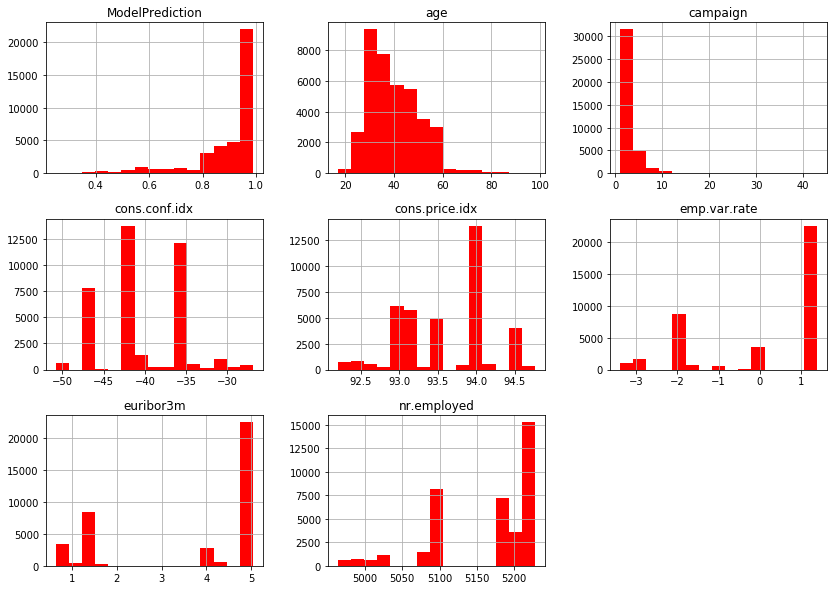

In [35]:
df.hist(figsize=(14,10),bins=15,color='r')

These histograms are displaying the distributions for all of the numerical features. The Main takeaways I got from the histograms:
- Age appears to be normally distributed.
- Campaign appears to be right skewed. 

## Exploratory Data Analysis

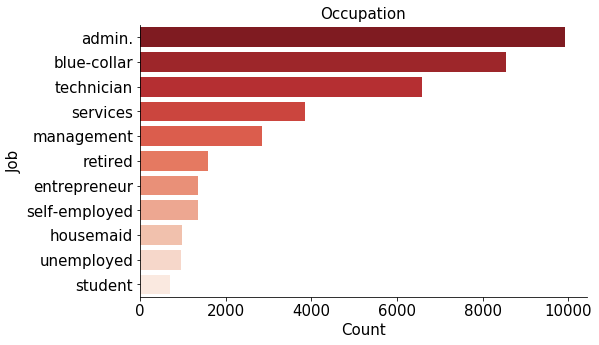

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
#qualitative_colors = sns.color_palette("Set3", 10)
diverging_colors = sns.color_palette("Reds_r", 11)

sns.barplot(df['job'].value_counts().values, df['job'].value_counts().index, palette= diverging_colors)
ax.set_xlabel('Count', fontsize=15)
ax.set_ylabel('Job', fontsize=15)
ax.set_title('Occupation', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

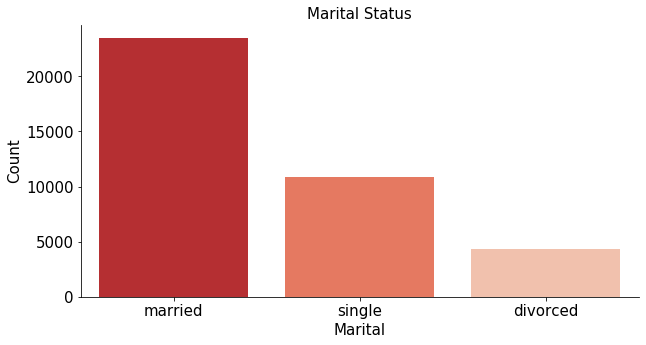

In [37]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 3)
fig.set_size_inches(10, 5)
sns.countplot(x = 'marital', data = df,palette = diverging_colors)
ax.set_xlabel('Marital', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Marital Status', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

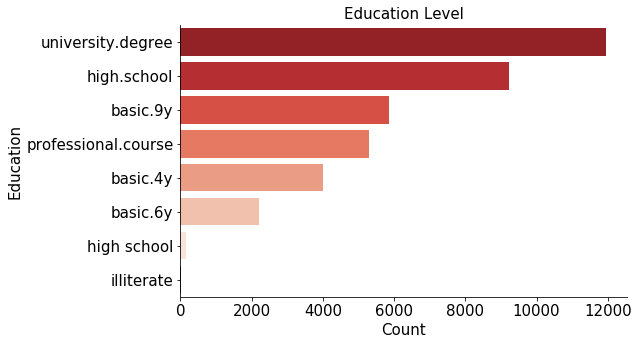

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
diverging_colors = sns.color_palette("Reds_r", 7)
sns.barplot(df['education'].value_counts().values, df['education'].value_counts().index, palette= diverging_colors)
ax.set_xlabel('Count', fontsize=15)
ax.set_ylabel('Education', fontsize=15)
ax.set_title('Education Level', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

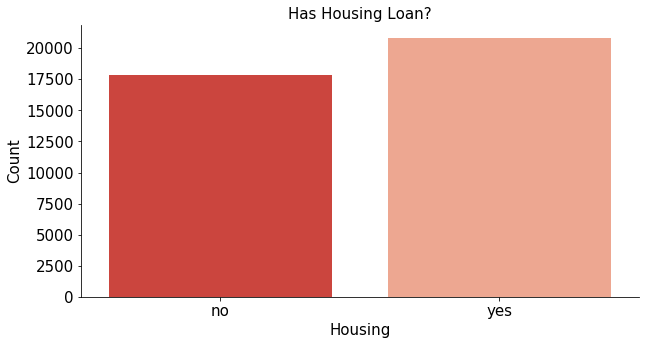

In [39]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 2)
fig.set_size_inches(10, 5)
sns.countplot(x = 'housing', data = df, palette= diverging_colors)
ax.set_xlabel('Housing', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Has Housing Loan?', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

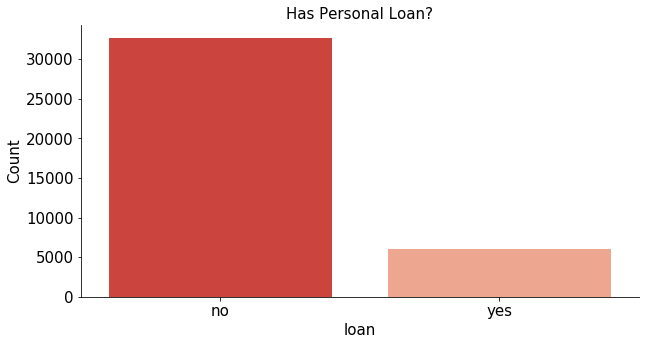

In [40]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 2)
fig.set_size_inches(10, 5)
sns.countplot(x = 'loan', data = df, palette= diverging_colors)
ax.set_xlabel('loan', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Has Personal Loan?', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

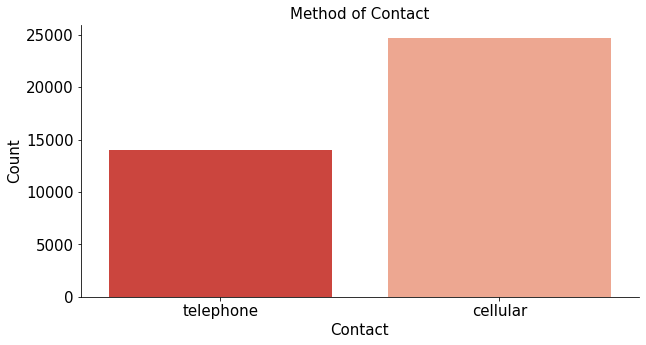

In [41]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 2)
fig.set_size_inches(10, 5)
sns.countplot(x = 'contact', data = df, palette= diverging_colors)
ax.set_xlabel('Contact', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Method of Contact', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

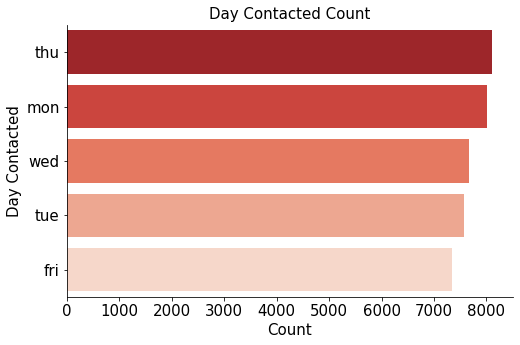

In [42]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 5)
fig.set_size_inches(8, 5)
sns.barplot(df['day_of_week'].value_counts().values, df['day_of_week'].value_counts().index, palette= diverging_colors)
ax.set_xlabel('Count', fontsize=15)
ax.set_ylabel('Day Contacted', fontsize=15)
ax.set_title('Day Contacted Count', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

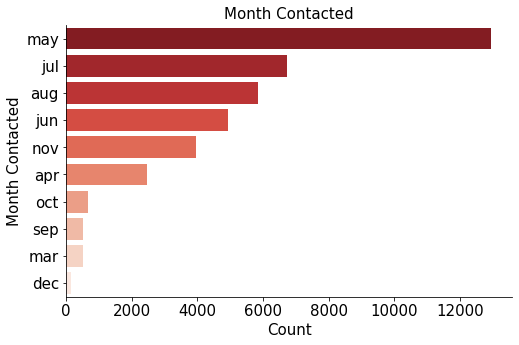

In [43]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 10)
fig.set_size_inches(8, 5)
sns.barplot(df['month'].value_counts().values, df['month'].value_counts().index, palette= diverging_colors)
ax.set_xlabel('Count', fontsize=15)
ax.set_ylabel('Month Contacted', fontsize=15)
ax.set_title('Month Contacted', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

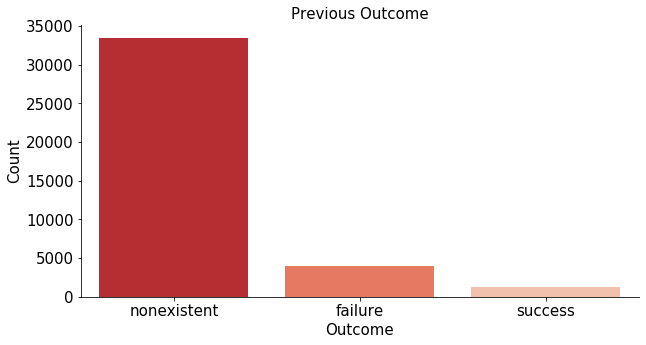

In [44]:
fig, ax = plt.subplots()
diverging_colors = sns.color_palette("Reds_r", 3)
fig.set_size_inches(10, 5)
sns.countplot(x = 'poutcome', data = df, palette= diverging_colors)
ax.set_xlabel('Outcome', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Previous Outcome', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

In [45]:
df.y.value_counts()

no     34388
yes     4320
Name: y, dtype: int64

According to the following plots I found:
- Admin, technician, and blue-collar occupations were the most commonly found in the dataset.
- The most occuring education level is a university degree.
- There was a small number of those who were students, entrepreneurs, and housemaids. 
- Large proportion of clients are married as opposed to divorced.
- A large proportion of clients have a housing loan, while very few have a personal loan.
- Cellular was the most common means of contact.
- The most contacts occured in May rather and the least in December. Important to note: Jan- Feb is missing.
- Most of the clients had not been previously contacted.
- Approximately 11% of people in the dataset subscribed to a term deposit.

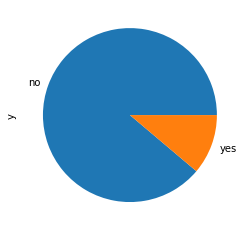

In [46]:
df.y.value_counts().plot(kind='pie')

This is showing that we are dealing with an imbalanced class. There are very few clients who subscribed compared to those who didn't.

## Relationship Between Dependent and Independent Variables

Now I will Investigate the relationship between the independent variables and the dependent variable (y - has the client subscribed a term deposit? (binary: 'yes','no'))

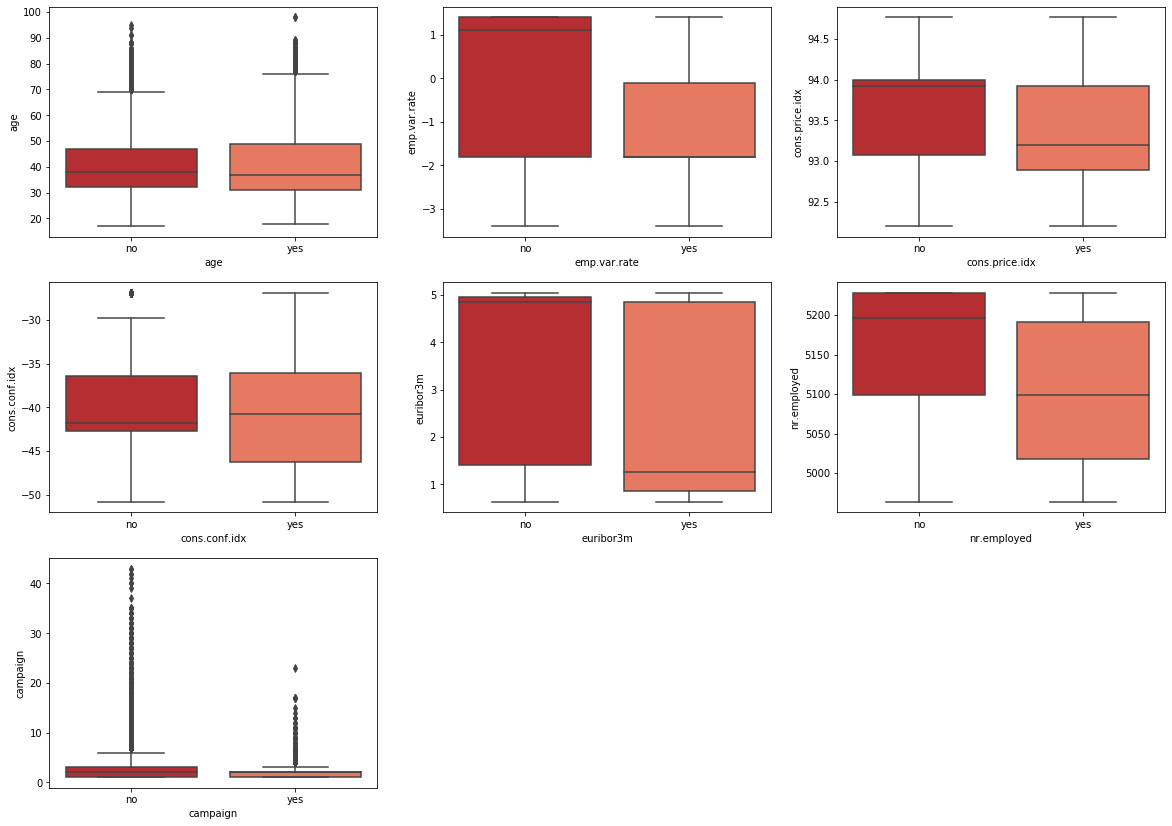

In [47]:
numeric_feat = ["age","emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed","campaign"]
plt.figure(figsize=(20,60), facecolor='white')
diverging_colors = sns.color_palette("Reds_r", 3)
plotnumber =1
for vals in numeric_feat:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x="y", y= df[vals], data=df, palette= diverging_colors)
    plt.xlabel(vals)
    plotnumber+=1
plt.show()

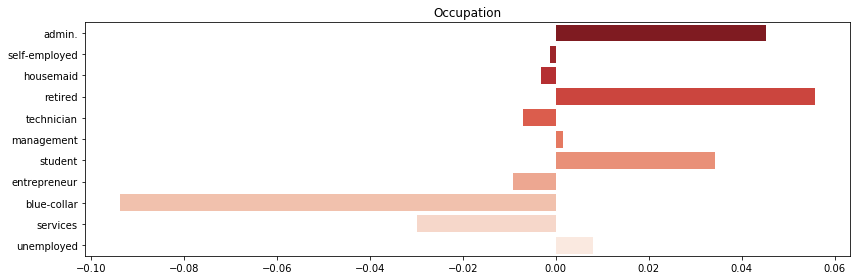

In [48]:
plt.figure(figsize=(12,4))
subscribe = df.loc[df.y.values == 'yes', 'job'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'job'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 11)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Occupation')
plt.tight_layout()

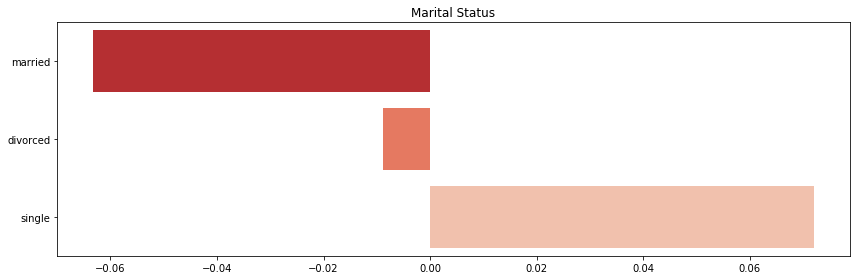

In [49]:
plt.figure(figsize=(12,4))
subscribe = df.loc[df.y.values == 'yes', 'marital'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'marital'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 3)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Marital Status')
plt.tight_layout()

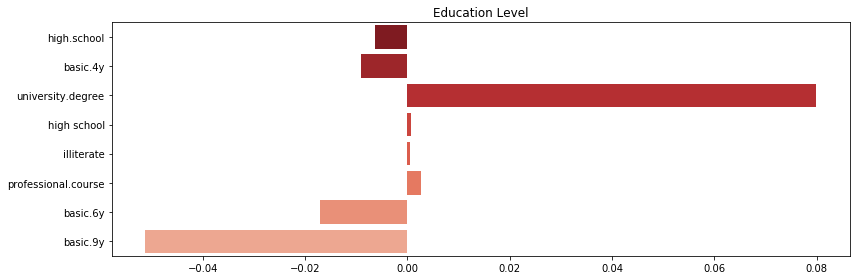

In [50]:
plt.figure(figsize=(12,4))
subscribe = df.loc[df.y.values == 'yes', 'education'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'education'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 11)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Education Level')
plt.tight_layout()

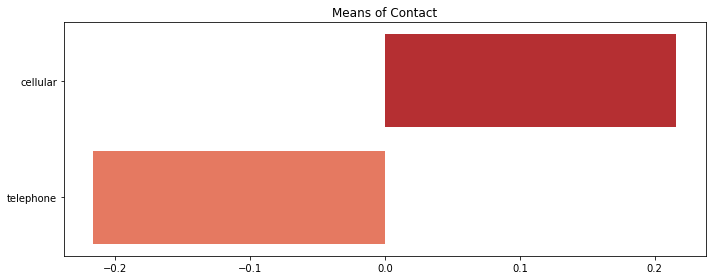

In [51]:
plt.figure(figsize=(10,4))
subscribe = df.loc[df.y.values == 'yes', 'contact'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'contact'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 3)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Means of Contact')
plt.tight_layout()

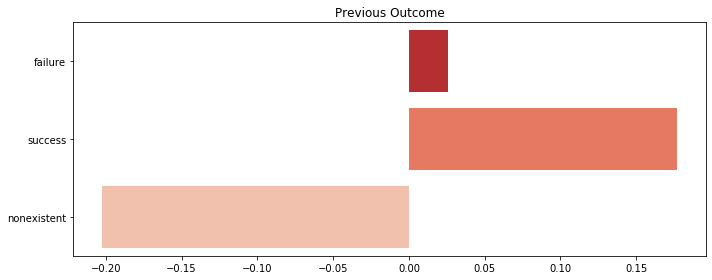

In [52]:
plt.figure(figsize=(10,4))
subscribe = df.loc[df.y.values == 'yes', 'poutcome'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'poutcome'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 3)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Previous Outcome')
plt.tight_layout()

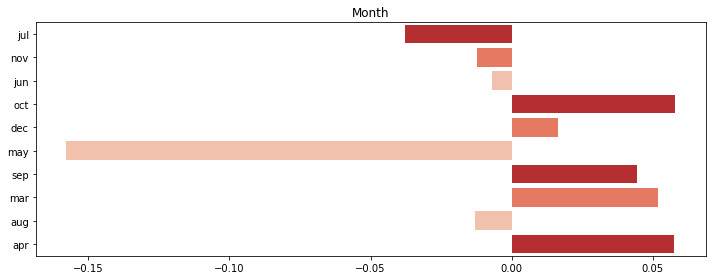

In [53]:
plt.figure(figsize=(10,4))
subscribe = df.loc[df.y.values == 'yes', 'month'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'month'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 3)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Month')
plt.tight_layout()

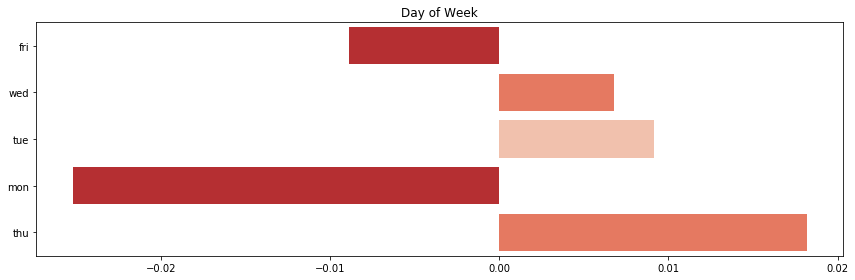

In [54]:
plt.figure(figsize=(12,4))
subscribe = df.loc[df.y.values == 'yes', 'day_of_week'].value_counts() 
no_subscribe = df.loc[df.y.values == 'no', 'day_of_week'].value_counts()
total = list(set(list(subscribe.index) + list(no_subscribe.index)))
diverging_colors = sns.color_palette("Reds_r", 3)
subscribe = subscribe.to_dict()
no_subscribe = no_subscribe.to_dict()
indicies = list(total)
total = [subscribe.get(k, 0) / (df.y.values == 'yes').sum() - no_subscribe.get(k, 0) / (df.y.values == 'no').sum() for k in total]
sns.barplot(total, indicies, palette= diverging_colors)
plt.title('Day of Week')
plt.tight_layout()

In [55]:
plt.figure(figsize=(25,5))
df["y"] = df["y"].replace(["yes","no"],[1,0])
corr_df = df[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','y']]
cor = corr_df.corr()
cor.style.background_gradient(cmap='coolwarm')

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1,0.00397526,-0.0044831,-0.00133919,0.129129,0.00700452,-0.0219482,0.0300757
campaign,0.00397526,1,0.150549,0.128425,-0.0120834,0.134588,0.143249,-0.0646606
emp.var.rate,-0.0044831,0.150549,1,0.775214,0.207863,0.972364,0.907679,-0.29296
cons.price.idx,-0.00133919,0.128425,0.775214,1,0.0676771,0.688903,0.523233,-0.132492
cons.conf.idx,0.129129,-0.0120834,0.207863,0.0676771,1,0.28893,0.111911,0.0509742
euribor3m,0.00700452,0.134588,0.972364,0.688903,0.28893,1,0.945276,-0.301766
nr.employed,-0.0219482,0.143249,0.907679,0.523233,0.111911,0.945276,1,-0.348947
y,0.0300757,-0.0646606,-0.29296,-0.132492,0.0509742,-0.301766,-0.348947,1


<Figure size 1800x360 with 0 Axes>

emp.var.rate, cons.price.idx, euribor3m, and nr.employed seem to be highly correlated with y. 

## Evaluating ModelPrediction 

I chose to evaluate ModelPrediction using precision and recall. A false positive for this dataset would mean that a client did not subscribe, however, the model classified them as a subscriber. A false negative means that the client subscribed but the model did labeled them as not subscribing. Ideally, we would like a model that has a low false pasitive and false negative rate. For this case, having a false positive is worse because false positives would misguide the company on who to target for their marketing campaign. Because of this, we will focus on precision and f1.

In [56]:
from sklearn.preprocessing import Binarizer

X = [df.ModelPrediction]
transformer = Binarizer(0.5).fit(X)
arr = transformer.transform(X)

df.loc[:, 'Pred'] = arr[0]
#df.loc[:, 'y'] = df['y'].replace(['yes', 'no'], [1, 0])

sum(df.y == df.Pred)/ len(df)

0.10173607522992663

In [57]:
TP, FP, TN, FN = 0, 0, 0, 0
for ind, row in df.iterrows():
    if row.Pred == 0: ## 0 prediction
        if row.Pred == row.y:
            TN +=1
        else: ## 0 prediction but really 1
            FN +=1
    else:
        if row.Pred == row.y:
            TP +=1
        else:
            FP +=1
            
            
print(TP, FP, TN, FN)
        
recall = TP/(TP + FN)
precision = TP/(TP + FP)
f1 = 2*(precision * recall)/(precision + recall)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)

3703 34153 235 617
Recall:  0.857175925925926
Precision:  0.09781804733727811
F1:  0.17559749620637333


The modelPrediction column has a very low precision and f1. I will now implement my own models to try to get a better precision and f1 scores.

# Implementation of Models

## Prepare Data

In [58]:
# Standardizing all numeric column
numeric_feat = ["age","emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed","campaign"]
numFeats = df[numeric_feat]
scaler = StandardScaler()
standScale = scaler.fit(numFeats)
standX= scaler.transform(numFeats)
standDF = pd.DataFrame(standX, columns = numeric_feat)

# Check to see it worked
standDF.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign
0,1.562765,0.648935,0.731741,0.894313,0.7124,0.328601,-0.565887
1,1.659842,0.648935,0.731741,0.894313,0.7124,0.328601,-0.565887
2,-0.281701,0.648935,0.731741,0.894313,0.7124,0.328601,-0.565887
3,0.009530,0.648935,0.731741,0.894313,0.7124,0.328601,-0.565887
4,1.562765,0.648935,0.731741,0.894313,0.7124,0.328601,-0.565887


In [59]:
# Replaces yes/no with 1/0 for binar variables
binary_df = df[['housing','loan','y']]
binary_df["housing"] = binary_df["housing"].replace(["yes","no"],[1,0])
binary_df["loan"] = binary_df["loan"].replace(["yes","no"],[1,0])

In [60]:
# Creating dummies for categorical variables
categorical = ['job','marital','education','contact','month','day_of_week','poutcome']
categorical_df = df[categorical]
cat_df = pd.get_dummies(categorical_df[categorical],drop_first = False)
cat_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [61]:
# Reset indexes so the three dataframes will align
cat_df= cat_df.reset_index(drop=True)
binary_df = binary_df.reset_index(drop=True)

In [62]:
print(cat_df.shape)
print(standDF.shape)
print(binary_df.shape)


(38708, 42)
(38708, 7)
(38708, 3)


In [63]:
# Combined all transformed features to one dataset
df_combined = pd.concat([cat_df, binary_df, standDF],axis=1)
df_combined.shape

(38708, 52)

In [64]:
#df_combined

In [65]:
plt.figure(figsize=(10,5))
cor = df_combined.corr()
cor.style.background_gradient(cmap='coolwarm')

<Figure size 720x360 with 0 Axes>

In [66]:
# Split data into training and testing set
X = df_combined.drop(['y'],axis=1)
y = df_combined['y']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)

In [67]:
# Code to deal with class imbalance 
X = pd.concat([X_train, y_train], axis=1)
no_deposit = X[X.y==0]
deposit = X[X.y==1]

# upsample minority
deposit_upsampled = resample(deposit,
                          replace=True, 
                          n_samples=len(no_deposit), 
                          random_state=27) 
upsampled = pd.concat([no_deposit, deposit_upsampled])

# check new class counts
upsampled.y.value_counts()
y_train = upsampled.y
X_train = upsampled.drop('y', axis=1)

In [68]:
# check new class counts
upsampled.y.value_counts()

1    27508
0    27508
Name: y, dtype: int64

We now have a balanced classed so there are the same amount of 'no' as 'yes'.

In [69]:
# Create Pipeline to run classification for logistic regression, decision trees, random forest, and K Nearest Neighbors 
# Set number of jobs 
n_jobs = -1
# Set State
random_state =12
# Logistic 
pipeline_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=700))])
# Decision Tree
pipeline_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])
# Random Forest
pipeline_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# KNN
pipeline_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
# Boosting
pipeline_gb = Pipeline([('gb', GradientBoostingClassifier(random_state=random_state))])

In [70]:
# Grid Search Parameters for each ML Model
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# Params for LR
params_lr = [{
                'lr__penalty': ['l1','l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
    }]
# Params for DT
params_dt = [{
                'dt__max_depth': [7, 8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7,9]
                }]
# Params for RF
params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [50, 80, 100],
                'rf__max_depth': [20,25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [50,60, 70]
                }]
# Params for KNN
params_knn = [{'knn__n_neighbors': [14,15,16,17,18]}]


# Params for GB
params_gb = [{
                'gb__max_depth': [25, 40,50],
                'gb__max_features': [2, 3],
                'gb__min_samples_leaf': [3, 4, 5],
                'gb__min_samples_split': [3,5,8],
                'gb__n_estimators': [50,60, 70]
                }]
#### Run Grid Search
# lR
lr = GridSearchCV(pipeline_lr, param_grid=params_lr,
                     scoring='precision', cv=cv) 
# DT
dt = GridSearchCV(pipeline_dt, param_grid=params_dt,
                     scoring='precision', cv=cv)
# RF
rf = GridSearchCV(pipeline_rf,params_rf,
                     scoring='precision', cv=cv)
# KNN
knn = GridSearchCV(pipeline_knn, param_grid=params_knn,
                     scoring='precision', cv=cv)
# GB
gb = RandomizedSearchCV(pipeline_gb,params_gb,
                     scoring='precision', cv=cv)

In [71]:
# models that we iterate over
model_evaluate = [lr, dt, rf, knn]
model_dictionary = {0:'Logistic ', 1:'Decision Tree', 2:'Random Forest', 3:'KNN',4:'Gradient Boosting'}

In [72]:
# set empty dicts and list
result_acc = {}
result_auc = {}
result_precision = {}
result_recall = {}
result_f1 = {}
models = []

for index, model in enumerate(model_evaluate):
        print()
        print('Start Model')
        print('Model: {}'.format(model_dictionary[index]))
        model.fit(X_train, y_train)
        y_preds= model.predict(X_test)
        print('---------------------------------------------')
        print('best params: {}'.format(model.best_params_))
        print('best score: is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        acc = accuracy_score(y_test, y_preds)
        prec = precision_score(y_test, y_preds)
        rec = recall_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds)
        print("ROC_AUC: ", auc)
        print("Accuracy: " , accuracy_score(y_test, y_preds))
        print("Recall: ", recall_score(y_test, y_preds))
        print("Precision: " ,precision_score(y_test, y_preds))
        print("F1 Score:  " ,f1_score(y_test, y_preds))
        print("Confusion Matrix : \n",confusion_matrix(y_test, y_preds))
        print("Classification Report: \n",classification_report(y_test, y_preds))
        print('End Model')
        print()
        models.append(model.best_estimator_)
        result_acc[index] = acc
        result_auc[index] = auc
        result_precision[index] = prec
        result_recall[index] = rec
        result_f1[index] = f1


Start Model
Model: Logistic 
---------------------------------------------
best params: {'lr__C': 0.7, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score: is 0.8086108927500242
ROC_AUC:  0.7828399847569201
Accuracy:  0.8296305864117799
Recall:  0.617169373549884
Precision:  0.3497698882314267
F1 Score:   0.4464960134284516
Confusion Matrix : 
 [[5891  989]
 [ 330  532]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      6880
           1       0.35      0.62      0.45       862

    accuracy                           0.83      7742
   macro avg       0.65      0.74      0.67      7742
weighted avg       0.88      0.83      0.85      7742

End Model


Start Model
Model: Decision Tree
---------------------------------------------
best params: {'dt__max_depth': 8, 'dt__min_samples_leaf': 1}
best score: is 0.8284407898782433
ROC_AUC:  0.7829746263422004
Accuracy:  0.8443554637044691
Recall:  0.5893271461716937

In [73]:
""" Model performance during Grid Search """
pd.DataFrame(list(zip(model_dictionary.values(), result_acc.values(), result_auc.values(),result_precision.values(),result_recall.values(), result_f1.values())), \
                  columns=['Model', 'Accuracy_rate','Roc_auc_rate','Precision','Recall','F1'])

,Model,Accuracy_rate,Roc_auc_rate,Precision,Recall,F1
0,Logistic,0.829631,0.782840,0.349770,0.617169,0.446496
1,Decision Tree,0.844355,0.782975,0.373804,0.589327,0.457452
2,Random Forest,0.852235,0.797342,0.394619,0.612529,0.480000
3,KNN,0.738440,0.742234,0.244844,0.647332,0.355301


The Random Forest algorithm was the best performing model. It was consistent in terms of having a good accuracy, auc rate, recall, and f1. 

In [74]:
rfmodel = RandomForestClassifier(criterion='entropy', max_depth= 25, min_samples_leaf= 80, min_samples_split= 3, n_estimators= 60) 
rfmodel.fit(X_train,y_train)
rfpred = rfmodel.predict(X_test)
print(classification_report(y_test, rfpred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      6880
           1       0.39      0.61      0.48       862

    accuracy                           0.85      7742
   macro avg       0.67      0.75      0.70      7742
weighted avg       0.89      0.85      0.86      7742



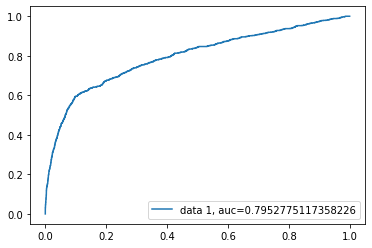

In [75]:
y_pred_proba = rfmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'RF Top 8 Importance Features')

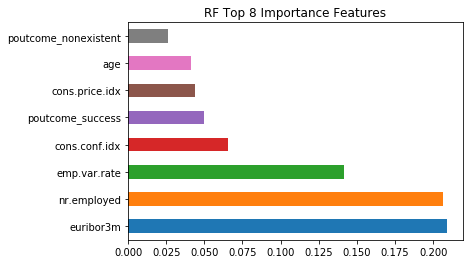

In [79]:
feat_importances = pd.Series(rfmodel.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.title('RF Top 8 Importance Features')